In [43]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from opencage.geocoder import OpenCageGeocode
import folium
from matplotlib.font_manager import FontProperties
import re

In [2]:
df = pd.DataFrame(pd.read_csv("../assets/normalized_pyramid_data.csv"))

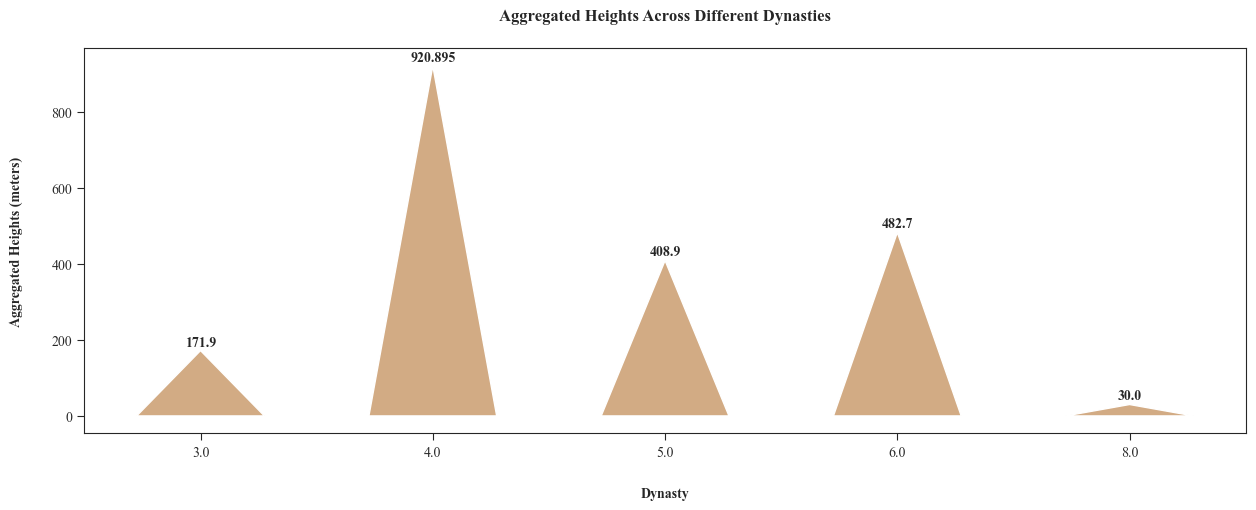

In [14]:
dynasty_heights=df[['dynasty','height']][pd.notnull(df['height'])]
#handle pyramids who have ranges by choosing median
dynasty_heights.at[18, 'height'] = 9.365
dynasty_heights.at[50, 'height'] = 16.5
dynasty_heights.at[22, 'height'] = 72

dynasty_heights['height']=dynasty_heights['height'].astype(float)
dynasty_heights=dynasty_heights.groupby('dynasty')['height'].sum().reset_index() 

#generate plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_style(style='ticks')
plt.rcParams['font.family'] = 'Times New Roman'

for i, (category, value) in enumerate(zip(dynasty_heights['dynasty'].to_list(), dynasty_heights['height'].to_list())):
    ax.fill([i-0.275, i, i+0.275], [0, value, 0], color='#d2ab84', alpha=1, edgecolor='white', linewidth=1.)
    ax.text(i, value + 5, f'{value}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(range(len(dynasty_heights['dynasty'].to_list())))
ax.set_xticklabels(dynasty_heights['dynasty'].to_list())
plt.tick_params(axis='both', which='major', length=5, labelsize=10) 


plt.title('Aggregated Heights Across Different Dynasties',fontweight='bold',pad=20, fontsize=12)
plt.xlabel('Dynasty',fontweight='bold',labelpad=20, fontsize=10)
plt.ylabel('Aggregated Heights (meters)', fontweight='bold',labelpad=20, fontsize=10)
plt.show()

In [36]:
sites_complexes=df[['site_or_location','casing','superstructure_type','royal_status']][df['site_or_location']!='Unknown']
sites_complexes = sites_complexes.groupby('site_or_location', sort=False).agg(
    kings_count=('royal_status', lambda x: sum(x == 'King')),
    queens_count=('royal_status', lambda x: sum(x == 'Queen'))
).reset_index()

#combine info about Saqqara into one
sites_complexes.drop([6,8], inplace = True)
sites_complexes['country']=['Egypt']*7
sites_complexes.at[0,'kings_count']=12
sites_complexes.at[0,'queens_count']=19

#get latitude and longitude values
key = '91fc143d65da4b8ba69d53e153d0fdef'
geocoder = OpenCageGeocode(key)
def geocode_address(row):
    location = geocoder.geocode(f"{row['site_or_location']},{row['country']}")
    if location and len(location):
        return location[0]['geometry']['lat'], location[0]['geometry']['lng']
    else:
        return None, None
    
#add latitude and longitude values to table 
sites_complexes['latitude'], sites_complexes['longitude'] = zip(*sites_complexes.apply(geocode_address, axis=1))

#plot map
egypt_map = folium.Map(location=[sites_complexes['latitude'].median(), sites_complexes['longitude'].median()], zoom_start=7.4)
for index, row in sites_complexes.iterrows():
        if 'Saqqara' == row['site_or_location']:
            color = 'red'
        elif row['site_or_location'] == 'Zawiyet el-Aryan':
            color = 'orange'
        elif row['site_or_location'] == 'Meidum':
            color = 'green'
        elif row['site_or_location'] == 'Dahshur':
            color = 'purple'
        elif row['site_or_location'] == 'Giza':
            color = 'blue'
        elif row['site_or_location'] == 'Abu Roash':
            color = 'darkblue'
        else:
            color = 'darkred'
        folium.Marker(
            [row['latitude'], row['longitude']], 
            icon=folium.Icon(color=color)
        ).add_to(egypt_map)

        folium.map.Marker(
                [row['latitude'], row['longitude']],
                icon=folium.DivIcon(
                    icon_size=(170,0),
                    icon_anchor=(170,0),
                    html=f"""
                    <div style="font-size: 11px; color: {color};font-weight: bold;background-color: white;text-align:center;border-radius: 5px; border: 1px solid black">
                    <b>Site:{row['site_or_location']}<br>
                    Kings #: {row['kings_count']}; Queens #: {row['queens_count']}
                    </div>
                    """
                )
            ).add_to(egypt_map)
egypt_map